# 🧠 Face Similarity Matching — GestaltMatcher Style

## 🔧 Install Required Packages

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python torch torchvision umap-learn tqdm ipywidgets

## 📚 Import Libraries

In [2]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import umap

## 🧠 Load Pretrained Model

We use ResNet18 from torchvision and remove the final classification layer.

In [3]:
resnet = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the final FC layer
model.eval()

C:\ProgramData\anaconda3\envs\ai_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ai_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## 🖼️ Define Image Preprocessing + Embedding Extraction

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def get_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor).squeeze().numpy()
    return embedding.flatten()

## 🔄 Extract Embeddings from Dataset

In [5]:
image_paths = glob.glob('images/*.jpg')[:]
embeddings = []
labels = []

for path in tqdm(image_paths):
    try:
        emb = get_embedding(path)
        embeddings.append(emb)
        labels.append(os.path.basename(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")

  0%|          | 0/10137 [00:00<?, ?it/s]

## 🤝 Compute Similarity to a Reference Face

In [9]:
image_paths = glob.glob('images/*.jpg')[:]
embeddings = []
labels = []

for path in tqdm(image_paths):
    try:
        emb = get_embedding(path)
        embeddings.append(emb)
        labels.append(os.path.basename(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")

  0%|          | 0/10137 [00:00<?, ?it/s]

## 🖼️ Display Reference and Similar Faces

In [10]:
def show_images(paths, title):
    fig, axs = plt.subplots(1, len(paths), figsize=(15, 5))
    # When only one image, axs is not a list, so make it a list
    if len(paths) == 1:
        axs = [axs]
    for ax, path in zip(axs, paths):
        img = Image.open(path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

## 🌐 UMAP Visualization of All Faces

C:\ProgramData\anaconda3\envs\ai_project\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ai_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


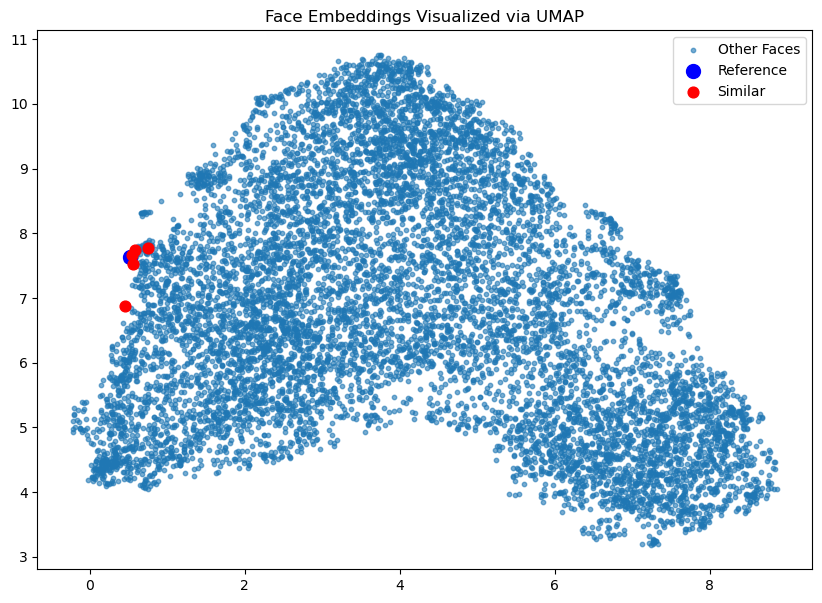

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

# Reference image index
reference_idx = 0  # or whichever you want as reference

# Compute cosine similarity of reference embedding with all others
ref_embedding = embeddings[reference_idx]
similarities = cosine_similarity([ref_embedding], embeddings)[0]

# Get top 5 most similar faces excluding the reference itself
top_indices = np.argsort(similarities)[::-1][1:6]

# Perform UMAP dimensionality reduction on all embeddings
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(embeddings)

# Plot all embeddings
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6, label='Other Faces')

# Highlight the reference face
plt.scatter(X_umap[reference_idx, 0], X_umap[reference_idx, 1], color='blue', label='Reference', s=100)

# Highlight the similar faces
for idx in top_indices:
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], color='red', label='Similar' if idx == top_indices[0] else "", s=60)

plt.legend()
plt.title("Face Embeddings Visualized via UMAP")
plt.show()
